In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [2]:
sys.path.insert(0,"/home/rzhu/Documents/nwn_l2l/")
from nwnTorch.misc import *

In [3]:
data_path = "/home/rzhu/data_access/l2l_data/logs/LTL-NWN-learn_snn-SA/run-no-2023-04-02-135654/"

fnames = os.listdir(data_path +"per_gen_trajectories")
fnames.sort()
n_gens = len(fnames)

In [4]:
results = []
for fn in fnames:
    fileName = os.path.join(data_path, "per_gen_trajectories", fn)
    temp = pkl_load(fileName)
    gen_out = torch.tensor([r[1][0] for r in temp.current_results])
    results.append(gen_out)

n_ins = len(gen_out)
results = torch.stack(results)

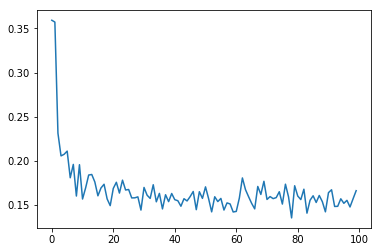

In [5]:
plt.plot(results.mean(axis = 1))

In [6]:
results.argmin(axis = 1)

tensor([ 4, 20,  6, 10,  8,  7,  6,  2, 19, 15, 21,  7, 14,  0,  4, 14,  7,  9,
        17,  1,  6,  1,  5,  5, 12, 21,  4, 23,  9, 23, 23, 20, 18,  1,  2,  8,
        21,  3, 23, 20,  2,  4,  5,  7,  1,  1,  8,  0,  1, 16,  5,  7, 20, 22,
        10, 23,  6, 22, 16, 12,  3, 11,  3,  9,  6,  8, 11, 11,  6,  6,  1,  2,
         6, 17,  4,  2, 20, 20, 15,  5,  1,  2,  6, 19, 11, 14, 22,  0,  8, 13,
        17,  8, 16,  1,  7, 13, 10, 19, 13, 11])

In [7]:
params = pkl_load(data_path+f"results/gen_{99:04d}_ind_{11:04d}.pkl")["params"]

In [8]:
sys.path.append("/home/rzhu/Documents/nwn_l2l/")
from nwnTorch.jn_models import *
from nwnTorch.nwn import *
from nwnTorch.generate_adj import *
from nwnTorch.misc import *

from tqdm import tqdm

In [66]:
def prepare_network(index = 0):
    snn_data_path = "/home/rzhu/data_access/l2l_data/snn_data_long/"
    adj = torch.tensor(pkl_load(snn_data_path + "con0.pkl")["adj_matrix"])
    net = NWN(adj, "sydney")

    # net.params["Ron"]       = 1e4
    # net.params["Roff"]      = 1e7
    net.params["Ron"]       = 1e1
    net.params["Roff"]      = 1e4

    net.params["grow"]      = 5
    net.params["decay"]     = 10
    net.params["precision"] = True
    net.params["collapse"]  = True
    net.params["dt"]        = 1e-3
    return net

In [67]:
snn_data_path = "/home/rzhu/data_access/l2l_data/snn_data_long/"
data_dict     = pkl_load(snn_data_path+f"snn_mem_{88}.pkl")
lambda_dict   = pkl_load(snn_data_path+"lambda_data.pkl")
params0       = pkl_load(data_path+f"results/gen_{0:04d}_ind_{0:04d}.pkl")["params"]
params        = pkl_load(data_path+f"results/gen_{99:04d}_ind_{11:04d}.pkl")["params"]

In [68]:
waves       = data_dict["waves"]
mems        = data_dict["mems"]
n_neurons   = mems.shape[-1]
num_inputs  = waves.shape[1]
num_steps   = waves.shape[0]
num_read    = 1024

torch.manual_seed(0)
shuffled = torch.randperm(1024)
e_in     = shuffled[:num_inputs]
e_read   = shuffled[-num_read:]
readout  = torch.zeros(num_steps, num_read)

In [96]:
# scale = 3 * 0.01
# scale = 3 
scale = .1 * 3 
net  = prepare_network()
# W_in = params["W_in"] * 3
# b_in = params["b_in"]
W_in = torch.rand(20) * scale * 2 - scale
b_in = torch.rand(20) * scale * 2 - scale
net.junction_state.L = lambda_dict["lambda"][0]

for i in tqdm(range(num_steps)):
    sig_in = W_in * waves[i] + b_in
    net.sim(sig_in.reshape(1,-1), e_in)
    readout[i,:] = net.V[e_read]

100%|██████████| 9000/9000 [03:33<00:00, 42.12it/s]


In [97]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel,RFECV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold


# Always scale the input. The most convenient way is to use a pipeline.
# reg = make_pipeline(StandardScaler(),
#             linear_model.SGDRegressor(max_iter=10000000, tol=1e-1))
# reg = make_pipeline(StandardScaler(),
#             linear_model.RidgeCV())

In [98]:
coefs = torch.zeros(20,1024)

for i in range(20):
    for j in range(1024):
        coefs[i,j] = abs(torch.corrcoef(torch.stack((waves[:,i], readout[:,j])))[0,1])

0.035978188874854426
0.18276205790824376
0.07250963618331592
0.07894557256442492
0.1725982576695881
0.20378038329472048
0.10855874264008543


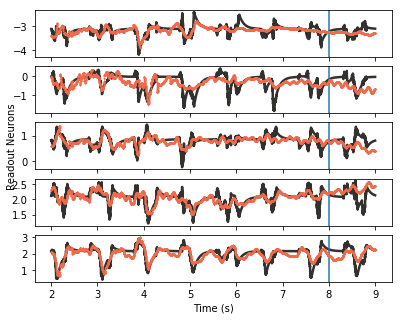

In [99]:
e_outs      = torch.argsort(coefs.mean(axis=0))[:64]
# e_outs = shuffled[-64:]
train_range = torch.arange(2000,8000)
test_range  = torch.arange(8000,9000)

predicts = []
alphas   = [1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1]
results  = []
tests    = []

for i in range(n_neurons):
    # lhs = readout[:,e_outs]
    lhs = torch.nn.functional.softmax(readout[:,e_outs], 0)
    rhs = mems[:,i]

    # weight, _, rcond = best_regress(lhs[train_range], rhs[train_range])
    # predict = weight @ lhs.T

    model = linear_model.RidgeCV(alphas = alphas, 
                                 cv=KFold(5), 
                                 )

    var_filter=SelectFromModel(model)
    # filter=feature_selection.SequentialFeatureSelector(model)
    


    # model = linear_model.LinearRegression()
    # model = linear_model.SGDRegressor(max_iter=1000000000, tol=1e-5)
    reg   = make_pipeline(
                StandardScaler(),
                var_filter, 
                model
                )
    
    reg.fit(lhs[train_range], rhs[train_range])
    predict = reg.predict(lhs)

    predicts.append(predict)
    print(mean_squared_error(predict[test_range], rhs[test_range]))
    # print(get_RNMSE(torch.tensor(predict), rhs))
    results.append(get_RNMSE(torch.tensor(predict[train_range]), rhs[train_range]))
    tests.append(mean_squared_error(predict[test_range], rhs[test_range]))
    # break
    # result[i] = get_RNMSE(predict, rhs)
    # break

fig, axes = plt.subplots(5,1, figsize = (6.4, 5))

for i in range(5):
    # axes[i].plot(np.arange(0,9,1e-3), mems[:,i], c = "#33312E", lw = 2.5, zorder = 1)
    axes[i].plot(np.arange(2,9,1e-3), mems[2000:,i], c = "#33312E", lw = 2.5, zorder = 1)
    # axes[i].scatter(np.arange(0,1,1e-3), play_dict0["predict"][:,i], c = "#5BC0BE", s = 1, zorder = 2)
    axes[i].scatter(np.arange(2,9,1e-3), predicts[i][2000:], c = '#EE6C4D', s = .5, zorder = 3)
    if i < 4: 
        axes[i].tick_params('x', labelbottom=False)
    axes[i].axvline(8)

plt.xlabel("Time (s)")
axes[2].set_ylabel("Readout Neurons")
print(np.array(results).mean())
print(np.array(tests).mean())